# "DEEP VISION CROWD MONITOR : AI FOR DENSITY ESTIMATION AND OVERCROWDING DETECTION"


>> Data Exploration & Density Map Preprocessing*


>> In this notebook, I explore the ShanghaiTech Part A dataset and perform preprocessing steps required for crowd counting.

>> This includes:

- Visualizing sample images  
- Extracting head-point annotations  
- Generating both fixed Gaussian density maps & adaptive (KNN-based) density maps  
- Comparing both methods

In [ ]:

import os
import cv2
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [ ]:
# ---------- Paths ----------
img_path = r"C:\Users\bolak\OneDrive\Desktop\deepvision\deepvision\ShanghaiTech\part_A\train_data\images"
gt_path = r"C:\Users\bolak\OneDrive\Desktop\deepvision\deepvision\ShanghaiTech\part_A\train_data\ground-truth"

Image file: C:\Users\bolak\OneDrive\Desktop\deepvision\deepvision\ShanghaiTech\part_A\train_data\images\IMG_1.jpg


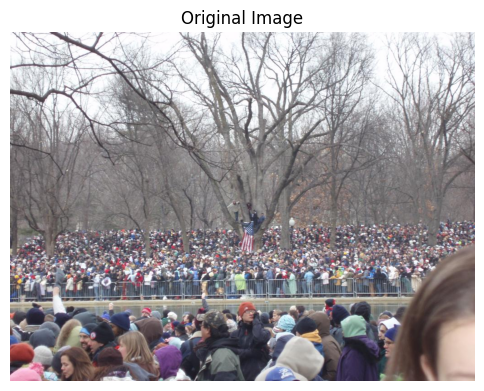

In [43]:
# ---------- Load first image ----------

img_files = [f for f in os.listdir(img_path) if f.endswith(('.jpg','.jpeg','.png'))]

if len(img_files) == 0:
    print("No images found!")
else:
    img_name = img_files[0]
    img_full = os.path.join(img_path, img_name)

    print("Image file:", img_full)

    # load the image
    img = cv2.imread(img_full)
    if img is None:
        print(f"Error: Could not read image from {img_full}")
        raise ValueError("Image failed to load")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")
    plt.show()


In [44]:
# ---------- Ground truth Annotations Visualization ----------
mat_name = "GT_" + img_name.replace(".jpg", ".mat").replace(".png",".mat")
mat_full = os.path.join(gt_path, mat_name)

print("MAT file path:", mat_full)

MAT file path: C:\Users\bolak\OneDrive\Desktop\deepvision\deepvision\ShanghaiTech\part_A\train_data\ground-truth\GT_IMG_1.mat


In [45]:
 # ---------- Load MAT file ----------
try:
        mat = scipy.io.loadmat(mat_full)
        print("Loaded MAT file successfully")
except Exception as e:
        print("Error reading MAT file:", e)
        raise

Loaded MAT file successfully


In [46]:
# ---------- Extract head points ----------
try:
        points = mat["image_info"][0][0][0][0][0]
        print("Number of annotated points:", len(points))
except:
        print("Failed to extract points. Let's inspect keys:", mat.keys())
        raise

Number of annotated points: 1546


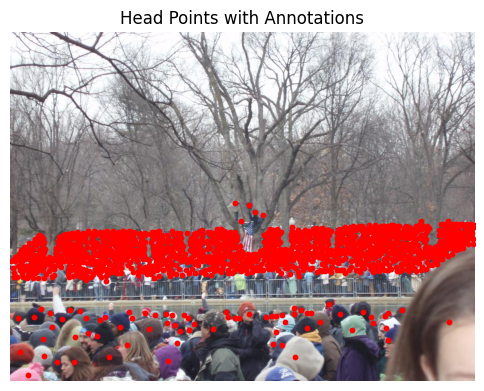

In [47]:
# ---------- Plot image + red points ----------
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.scatter(points[:,0], points[:,1], s=10, color='red')
plt.title("Head Points with Annotations")
plt.axis("off")
plt.show()

Image shape: (768, 1024)
Number of annotated heads: 1546
Sum before blurring (should equal N): 1546.0


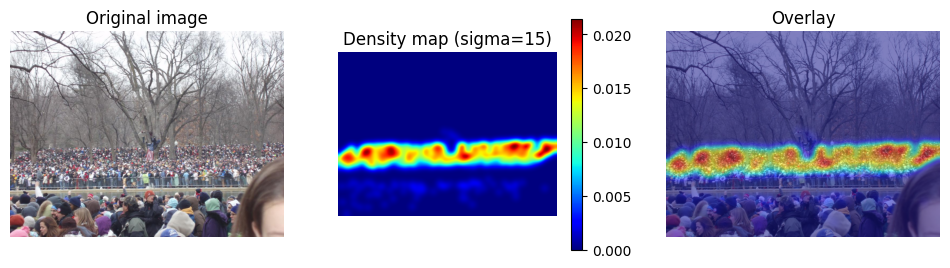

Sum after blurring (should still be ~N): 1546.0002


In [48]:
# ---------- Create density map using fixed sigma----------

H, W = img.shape[0], img.shape[1] # height, width
print("Image shape:", (H, W))
print("Number of annotated heads:", len(points))

# 1) Create empty density map (float32)
density = np.zeros((H, W), dtype=np.float32)

# 2) Put 1 at each head location
# points are [x, y] where x is horizontal, y is vertical.
for (x, y) in points:
    xi = int(round(x))
    yi = int(round(y))
    # boundary check (in case a point sits on the very edge)
    if 0 <= yi < H and 0 <= xi < W:
        density[yi, xi] += 1.0

# Quick sanity: sum should equal number of points
print("Sum before blurring (should equal N):", density.sum())

# 3) Apply Gaussian smoothing 
sigma = 15    # controls spread; -- fixed sigma
density_blurred = gaussian_filter(density, sigma=sigma)

# 4) Visualize 
plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(density_blurred, cmap='jet')
plt.title(f"Density map (sigma={sigma})")
plt.colorbar(shrink=0.6)
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img)
plt.imshow(density_blurred, cmap='jet', alpha=0.5)   # overlay
plt.title("Overlay")
plt.axis("off")

plt.show()

print("Sum after blurring (should still be ~N):", density_blurred.sum())

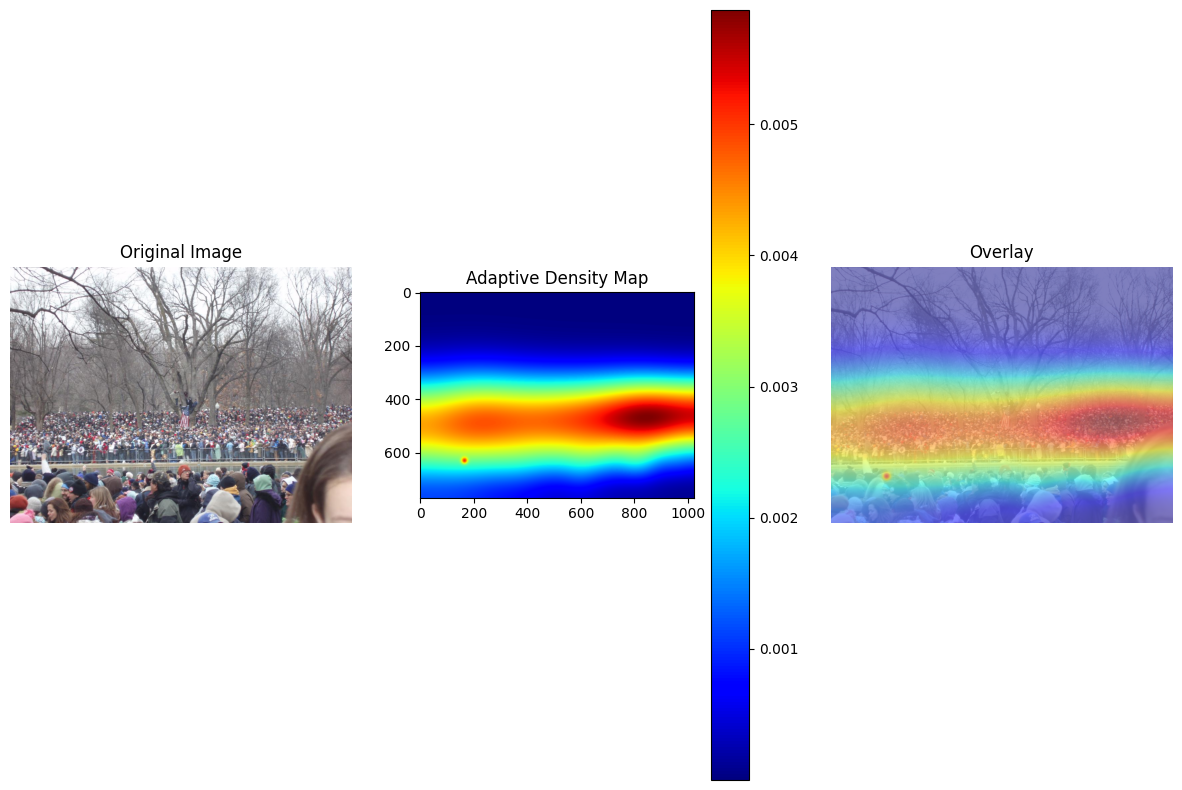

Sum after blurring (should still be ~N): 1536.3704


In [ ]:
# ---------- Create density map using Adaptive sigma----------

from scipy.spatial import KDTree
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt

def adaptive_density(img_shape, points, k=3, std_scale=0.3):
    h, w = img_shape[0], img_shape[1]
    density = np.zeros((h, w), dtype="float32")

    if len(points) == 0:
        print("⚠ No points found")
        return density

    if len(points) == 1:
        print("⚠ Only one point → Using fixed sigma=15")
        x, y = int(points[0][0]), int(points[0][1])
        density[y, x] = 1
        return gaussian_filter(density, sigma=15)

    # KNN + adaptive sigma
    tree = KDTree(points)

    for p in points:
        distances, _ = tree.query(p, k=min(k+1, len(points)))
        sigma = std_scale * np.mean(distances[1:])

        x, y = int(p[0]), int(p[1])
        density[y, x] = 1

        density = gaussian_filter(density, sigma=sigma)
       
    return density

# ----- Generate density -----
density = adaptive_density(img.shape, points)

# ----- Plot -----
plt.figure(figsize=(15,10))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(density, cmap='jet')
plt.title("Adaptive Density Map")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(img, alpha=0.5)
plt.imshow(density, cmap='jet', alpha=0.5)
plt.title("Overlay")
plt.axis("off")

plt.show()

density_blurred = gaussian_filter(density, sigma=sigma)
print("Sum after blurring (should still be ~N):", density_blurred.sum())


##  Comparison – Fixed vs Adaptive

### *Fixed Sigma Map*
- Easy to implement  
- Same blur size for every head  
- Works OK for uniform crowds  

### *Adaptive Sigma Map*
- Uses distance to nearest neighbours  
- Captures dense vs sparse crowd variations  
- Produces more realistic visual density maps  
- Used in CSRNet and other research papers  

Both visualizations worked successfully.

## Conclusion

In this notebook, I completed:

- Dataset loading  
- Image exploration  
- Annotation visualization  
- Fixed density map  
- Adaptive density map  
- Interpretation of results  

This completes *data exploration & preprocessing* required for the Deep Vision.